In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import time

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
from model import config_default, model_data, TransformerModel, generate_from_model, validation

sizes of train, val, test = 1003862, 55778, 55778
vocab size = 66, unique chars:
['\n', ' ', '!', '"', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [6]:
config_default['n_feature'] = 2048
config_default['lambda'] = 5 # regularization term in SAE loss
config_default['layer_for_SAE'] = 6 # SAE after this layer
config_default

{'n_layer': 6,
 'n_model': 256,
 'n_ff': 1024,
 'n_head': 8,
 'head_size': 32,
 'n_context': 256,
 'n_token': 66,
 'RoPE': True,
 'dropout': 0.2,
 'n_batch': 64,
 'lr': 0.0003,
 'weight_decay': 0.1,
 'n_feature': 2048,
 'lambda': 5,
 'layer_for_SAE': 6}

# Try loading model

In [7]:
DEFAULT_MODEL = "model.10000.pth"

In [8]:
if False:
    model = TransformerModel()
    model.to(DEVICE)
    model.load_state_dict(torch.load(DEFAULT_MODEL))
    _ = generate_from_model(model)
    _ = validation(model, print_loss=True)

# Sparse autoencoder

In [8]:
class TransformerWithSAE(TransformerModel):
    def __init__(self, config=config_default):
        super().__init__()
        # freeze old parameters
        for p in self.parameters():
            p.requires_grad = False
        # switch to eval mode (this is mainly for dropout and does not affect SAE)
        self.eval()
        # SAE
        self.W_enc = nn.Parameter(torch.randn(config['n_feature'], config['n_model'])/np.sqrt(config['n_model']))
        self.W_dec = nn.Parameter(self.W_enc.data)
        self.b_enc = nn.Parameter(torch.zeros(config['n_feature']))
        self.b_dec = nn.Parameter(torch.zeros(config['n_model']))
        # other SAE parameters
        self.lam = config['lambda']
        self.layer_for_SAE = config['layer_for_SAE']
        self.scale_factor = 1 # should be updated by calling self.update_scale_factor()
    def forward(self, t, y=None, SAE_loss=False):
        """
        SAE loss:
        determines whether to output feature amp + SAE loss
        or logits + model loss (corss entropy with y)
        (default to False so that model.generate() works properly)
        """
        # run until SAE
        x = self.embed(t)
        x_in = self.layers[:self.layer_for_SAE](x) * self.scale_factor
        # SAE
        features = torch.einsum('...i,ji->...j',x_in,self.W_enc) + self.b_enc
        features = F.relu(features)
        x_out = torch.einsum('...i,ij->...j',features,self.W_dec) + self.b_dec
        # SAE loss
        if SAE_loss:
            # loss function from here:
            # https://transformer-circuits.pub/2024/april-update/index.html#training-saes
            L2_loss = torch.sum((x_out-x_in)**2, axis=-1)
            reuglarization = self.lam*torch.sum(features*torch.norm(self.W_dec,dim=-1), axis=-1) # feature is non-negative already
            loss = torch.mean(L2_loss + reuglarization)
            return features, loss
        # after SAE
        x = self.layers[self.layer_for_SAE:](x_out*(1./self.scale_factor))
        x = self.final_norm(x)
        logits = self.final_lin(x)
        if y is None:
            return logits, None
        logits = logits.view(-1,self.n_token)
        y = y.view(-1)
        loss = F.cross_entropy(logits, y)
        return logits, loss
    @torch.no_grad()
    def update_scale_factor(self, model_data=model_data, indices=range(256*1,256*(1+256*14),256*14)):
        """
        draw a sample from model data and use it to compute scale factor
        for reproducbility, the indices are fixed to 256 contexts (256*256 activations)
        across the training set
        """
        d = model_data.x_train
        t = torch.stack([d[i:i+model_data.n_context] for i in indices])
        x = self.embed(t)
        x = self.layers[:self.layer_for_SAE](x)
        # scale so that x^2 = n_model - so element-wise x_i^2 averages to 1
        self.scale_factor = torch.mean(x**2).item()**-0.5
        # print(f"scale action by {self.scale_factor:.3e}")
        return

In [10]:
# example usage
if False:
    SAEmodel = TransformerWithSAE()
    SAEmodel.to(DEVICE)
    SAEmodel.load_state_dict(torch.load(DEFAULT_MODEL), strict=False)
    SAEmodel.update_scale_factor()
    _ = generate_from_model(SAEmodel)

# Training diagnostics

In [9]:
def plot_performance(model, validation=True, **kwargs):
    p,=plt.plot(model.losses, **kwargs)
    if validation:
        plt.plot(model.diag_epochs, model.diag_train_loss, ls='-', marker='.', color=p.get_color())
        plt.plot(model.diag_epochs, model.diag_val_loss, ls=':', marker='.', color=p.get_color())
    return

In [12]:
n_batch = 64
lr = 3e-4
def new_model(validation_interval=None, config=config_default):
    model = TransformerWithSAE(config)
    model.to(DEVICE)
    model.load_state_dict(torch.load(DEFAULT_MODEL), strict=False)
    model.update_scale_factor()
    # print(f"{np.sum([p.numel() for p in model.parameters() if p.requires_grad])/1e6:.4f}M parameters")
    # additional params
    if validation_interval is None:
        model.validation_interval = int(20 * 256/n_batch) # validation evaluation ~ 10% training evaluation
    else:
        model.validation_interval = validation_interval
    model.total_time = 0
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    return model, optimizer
model, optimizer = new_model()

In [11]:
def training_loop(t_max=3600, n_max=1000, lam=5, n_lam=1, scheduler=None, clip=True):
    t_start = time.time()
    t_now = time.time()
    for i in range(n_max):
        if (t_now-t_start) > t_max: break
        # validation
        if model.validation_interval>0 and model.current_epoch%model.validation_interval==0:
            model.lam = 0
            tl, vl = validation(model, SAE_loss=True, print_loss=True)
            model.diag_epochs.append(model.current_epoch)
            model.diag_train_loss.append(tl)
            model.diag_val_loss.append(vl)
        model.lam = min(1., model.current_epoch/n_lam) * lam
        x, y = model_data.draw(n_batch)
        optimizer.zero_grad()
        _, loss = model(x, y, SAE_loss=True)
        loss.backward()
        if clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        model.losses.append(loss.item())
        model.current_epoch += 1
        t_now = time.time()
    model.total_time += t_now - t_start
    print(f"took {t_now - t_start:.2f}s, total time {model.total_time:.2f}s, current epoch {model.current_epoch}")

# Training
After some tuning, it seems that the best option (given a target of finishing within 10K epochs) is to start from a lower learning rate without clipping, then switch to a higher learning rate with clipping. Tests suggest that batch size does not seem to matter too much. Maybe I should come back and train an SAE with 10x epochs and 10x lower learning rate. But maybe right now it's already close to an optimum since a few different treatments all converge to roughly the same plateau.

Note on choice of $\lambda$: assuming an equipartition between sparsity loss and L2 loss, we have the following relation: n_model * relative_mse ~ lambda * sqrt(n_model/n_active) where n_active is the typical number of simulatenously active features. So it is appropriate to choose a smaller $\lambda$ for a less sparse model (i.e. larger n_active/n_model). And my model is likely less sparse than those trained on a more diverse corpus. So I'm reducing $\lambda$ to 2.

In [210]:
n_batch = 64
lr = 3e-4
model, optimizer = new_model(validation_interval=100)

In [211]:
training_loop(n_max=2000, lam=2, n_lam=200, clip=False)

epoch 0, train loss = 3065.2383, val loss = 3036.5217
epoch 100, train loss = 108.0964, val loss = 107.3223
epoch 200, train loss = 101.2931, val loss = 100.3644
epoch 300, train loss = 97.8688, val loss = 94.8218
epoch 400, train loss = 89.8758, val loss = 87.7279
epoch 500, train loss = 83.9165, val loss = 82.4609
epoch 600, train loss = 78.9971, val loss = 77.2773
epoch 700, train loss = 75.4880, val loss = 73.5630
epoch 800, train loss = 71.9116, val loss = 70.3291
epoch 900, train loss = 68.8827, val loss = 67.3131
epoch 1000, train loss = 66.2184, val loss = 64.5597
epoch 1100, train loss = 63.6844, val loss = 62.1293
epoch 1200, train loss = 61.1828, val loss = 59.7473
epoch 1300, train loss = 58.9788, val loss = 58.0851
epoch 1400, train loss = 57.1258, val loss = 56.0238
epoch 1500, train loss = 55.7283, val loss = 54.5913
epoch 1600, train loss = 54.2226, val loss = 52.8263
epoch 1700, train loss = 52.5954, val loss = 51.6773
epoch 1800, train loss = 51.6857, val loss = 50.59

In [212]:
# switch to higher lr and clipped norm
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
training_loop(n_max=8000, lam=2, n_lam=200, clip=True)

epoch 2000, train loss = 49.4746, val loss = 47.9025
epoch 2100, train loss = 34.6510, val loss = 34.4384
epoch 2200, train loss = 31.1614, val loss = 31.4373
epoch 2300, train loss = 29.0756, val loss = 29.7065
epoch 2400, train loss = 28.2244, val loss = 28.8118
epoch 2500, train loss = 27.5864, val loss = 28.3629
epoch 2600, train loss = 26.9389, val loss = 27.5165
epoch 2700, train loss = 27.0484, val loss = 27.8719
epoch 2800, train loss = 26.6650, val loss = 27.3222
epoch 2900, train loss = 25.9549, val loss = 26.9134
epoch 3000, train loss = 26.3151, val loss = 27.0891
epoch 3100, train loss = 25.4413, val loss = 26.3573
epoch 3200, train loss = 26.5258, val loss = 27.4906
epoch 3300, train loss = 26.2205, val loss = 27.1018
epoch 3400, train loss = 25.8412, val loss = 26.7093
epoch 3500, train loss = 25.9584, val loss = 26.8665
epoch 3600, train loss = 25.5371, val loss = 26.2258
epoch 3700, train loss = 25.1231, val loss = 25.7590
epoch 3800, train loss = 25.4120, val loss = 2

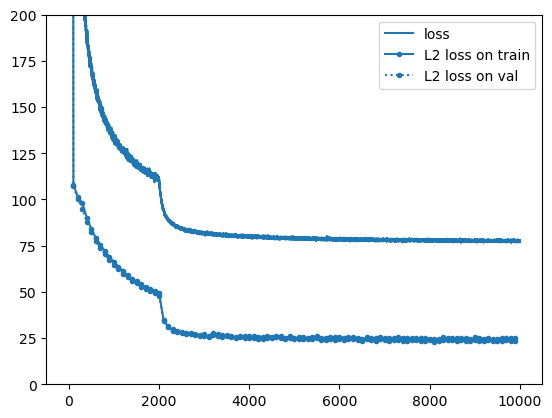

In [232]:
plot_performance(model)
plt.ylim(0,200)
plt.legend(['loss','L2 loss on train','L2 loss on val'])

(75.0, 85.0)

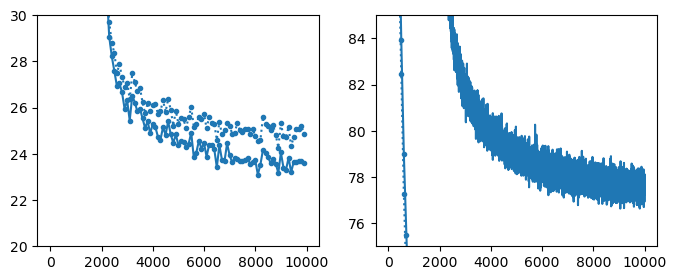

In [217]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
plt.sca(ax[0])
plot_performance(model)
plt.ylim(20,30)
plt.sca(ax[1])
plot_performance(model)
plt.ylim(75,85)

In [227]:
#torch.save(model.state_dict(), 'SAE_L6.10000.pth')

# Some basic diagnostics

In [233]:
_ = generate_from_model(model)

not:
Sirrah young gamester, your father were a fool
To give thee all, and in his waning age
Set foot under thy table: tut, a toy!
An old Italian fox is not so kind, my boy.

TRANIO:
A vengeance on your crafty wither'd hide!
Yet I have faced it with a card an at cotenten your and
Of counsin; then
I he, resensit me thy sunse son, were to thy leary I
Stably of very side are pie reme nor and honour?
And descare her
Touse hatr bloot atior unfather echaris wrate.
Haris in droown 'Where the undeer,---
It thit is should gone us to word, withal
Ha then the good the faith, that some be-most sign.
What father my toorse a man mand in of the bread!

FLORIZENTH:
O do folset else me are I ill a all bittter.

LORD S:
Mork withis Allace, his lookss, most saw bare may,
Thou i


In [234]:
model_base = TransformerModel()
model_base.to(DEVICE)
model_base.load_state_dict(torch.load(DEFAULT_MODEL))

_ = validation(model_base, print_loss=True)
_ = validation(model, print_loss=True)

epoch 0, train loss = 1.2218, val loss = 1.4648
epoch 10000, train loss = 1.4231, val loss = 1.6281


In [236]:
print(f"percentage of loss recovered = {1.4648/1.6281:.3f}")

percentage of loss recovered = 0.900


In [237]:
x, y = model_data.draw(1024)
features, loss = model(x, y, SAE_loss=True)
features = features.cpu().detach().numpy()

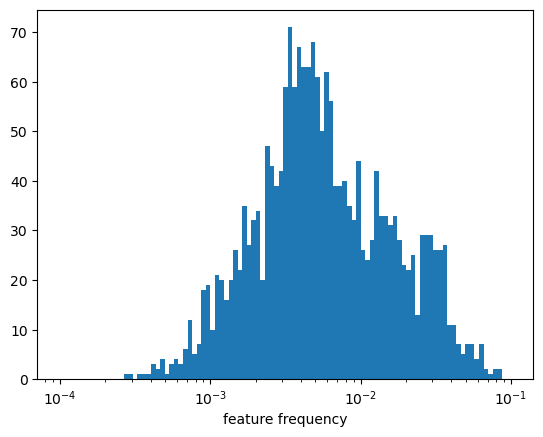

In [241]:
frequency = np.sum(features>0, axis=(0,1))/(features.shape[0]*features.shape[1])
plt.hist(frequency, bins = np.logspace(-4,-1,100))
plt.xlabel('feature frequency')
plt.xscale('log')

In [242]:
print(f"{np.sum(frequency==0)} dead features")

1 dead features


In [244]:
print(f"{np.sum(frequency):.2f} active features on average")

20.07 active features on average


Text(0.5, 0, 'number of simultaneously active features')

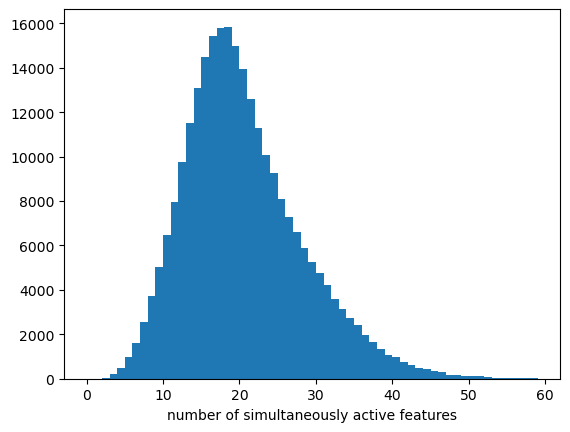

In [248]:
n_active = np.sum(features>0, axis=-1).flatten()
plt.hist(n_active, bins=np.arange(60))
plt.xlabel('number of simultaneously active features')

# Train another SAE at a different layer

In [13]:
config = config_default.copy()
config['layer_for_SAE'] = 3

n_batch = 64
lr = 3e-4
model, optimizer = new_model(validation_interval=100, config=config)

In [14]:
training_loop(n_max=2000, lam=2, n_lam=200, clip=False)

epoch 0, train loss = 3094.7222, val loss = 3123.0186
epoch 100, train loss = 47.6911, val loss = 47.7282
epoch 200, train loss = 68.3878, val loss = 69.1619
epoch 300, train loss = 56.1553, val loss = 57.1703
epoch 400, train loss = 43.1496, val loss = 44.0311
epoch 500, train loss = 34.1114, val loss = 34.7093
epoch 600, train loss = 27.8820, val loss = 28.6265
epoch 700, train loss = 23.4151, val loss = 24.0009
epoch 800, train loss = 20.3409, val loss = 20.4950
epoch 900, train loss = 17.6813, val loss = 18.1529
epoch 1000, train loss = 16.0754, val loss = 16.3352
epoch 1100, train loss = 15.0433, val loss = 15.0063
epoch 1200, train loss = 14.1164, val loss = 14.1021
epoch 1300, train loss = 13.1792, val loss = 13.2193
epoch 1400, train loss = 12.7133, val loss = 12.8949
epoch 1500, train loss = 11.9300, val loss = 12.1379
epoch 1600, train loss = 11.5108, val loss = 11.4798
epoch 1700, train loss = 11.1218, val loss = 11.1426
epoch 1800, train loss = 10.6427, val loss = 10.6436
e

In [19]:
# switch to higher lr and clipped norm
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
training_loop(n_max=8000, lam=2, n_lam=200, clip=True)

epoch 2000, train loss = 9.9723, val loss = 9.9310
epoch 2100, train loss = 7.2710, val loss = 7.3263
epoch 2200, train loss = 6.2368, val loss = 6.2639
epoch 2300, train loss = 5.9226, val loss = 5.9252
epoch 2400, train loss = 5.6749, val loss = 5.7273
epoch 2500, train loss = 5.3946, val loss = 5.4963
epoch 2600, train loss = 5.2827, val loss = 5.2959
epoch 2700, train loss = 5.3572, val loss = 5.3278
epoch 2800, train loss = 5.3233, val loss = 5.3013
epoch 2900, train loss = 5.2861, val loss = 5.3044
epoch 3000, train loss = 5.0981, val loss = 5.1351
epoch 3100, train loss = 5.1537, val loss = 5.1490
epoch 3200, train loss = 5.2161, val loss = 5.1788
epoch 3300, train loss = 5.0244, val loss = 5.0637
epoch 3400, train loss = 5.0338, val loss = 5.2189
epoch 3500, train loss = 5.1597, val loss = 5.1493
epoch 3600, train loss = 5.1093, val loss = 5.1479
epoch 3700, train loss = 5.0483, val loss = 5.0016
epoch 3800, train loss = 5.2174, val loss = 5.1878
epoch 3900, train loss = 5.0661

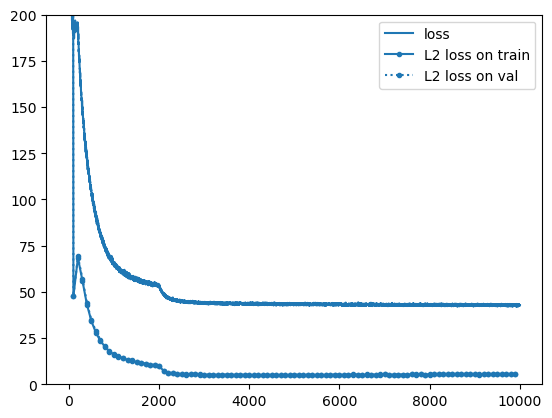

In [20]:
plot_performance(model)
plt.ylim(0,200)
plt.legend(['loss','L2 loss on train','L2 loss on val'])

(40.0, 50.0)

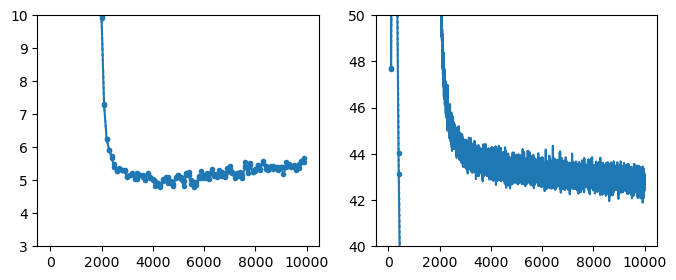

In [22]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
plt.sca(ax[0])
plot_performance(model)
plt.ylim(3,10)
plt.sca(ax[1])
plot_performance(model)
plt.ylim(40,50)

In [25]:
#torch.save(model.state_dict(), 'SAE_L3.10000.pth')

In [23]:
x, y = model_data.draw(1024)
features, loss = model(x, y, SAE_loss=True)
features = features.cpu().detach().numpy()
frequency = np.sum(features>0, axis=(0,1))/(features.shape[0]*features.shape[1])
print(f"{np.sum(frequency==0)} dead features")
print(f"{np.sum(frequency):.2f} active features on average")

708 dead features
10.62 active features on average


In [24]:
model_base = TransformerModel()
model_base.to(DEVICE)
model_base.load_state_dict(torch.load(DEFAULT_MODEL))

_ = validation(model_base, print_loss=True)
_ = validation(model, print_loss=True)

epoch 0, train loss = 1.2308, val loss = 1.4908
epoch 10000, train loss = 1.3452, val loss = 1.5622
